In [3]:
import os
import torchvision
from torchvision import datasets, transforms
import torch
from torch.utils.data import DataLoader, ConcatDataset, Subset
from collections import Counter
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

# Téléchargement des données

In [6]:
path = "/kaggle/input/datasets/paultimothymooney/chest-xray-pneumonia"

# Petit test pour être sûr que les dossiers sont là
if os.path.exists(path):
    print("✅ Dataset trouvé !")
    print("Dossiers disponibles :", os.listdir(path))
else:
    print("❌ Dataset non trouvé. Vérifie si tu as cliqué sur '+ Add Data' à droite.")

✅ Dataset trouvé !
Dossiers disponibles : ['chest_xray']


# Statistique

## On détermine le nombre d'images par dossier

chest_xray/train

Class: NORMAL, Number of images: 1341, percentage: 25.71%
Class: PNEUMONIA, Number of images: 3875, percentage: 74.29%
Number of images:  5216 
Classes:  ['NORMAL', 'PNEUMONIA'] 
Class to index mapping:  {'NORMAL': 0, 'PNEUMONIA': 1} 



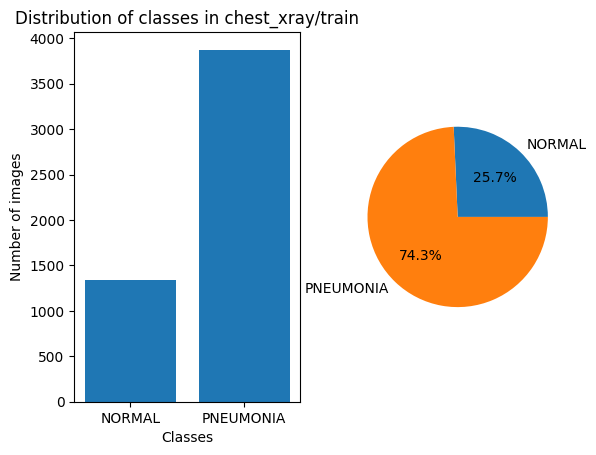

chest_xray/test

Class: NORMAL, Number of images: 234, percentage: 37.50%
Class: PNEUMONIA, Number of images: 390, percentage: 62.50%
Number of images:  624 
Classes:  ['NORMAL', 'PNEUMONIA'] 
Class to index mapping:  {'NORMAL': 0, 'PNEUMONIA': 1} 



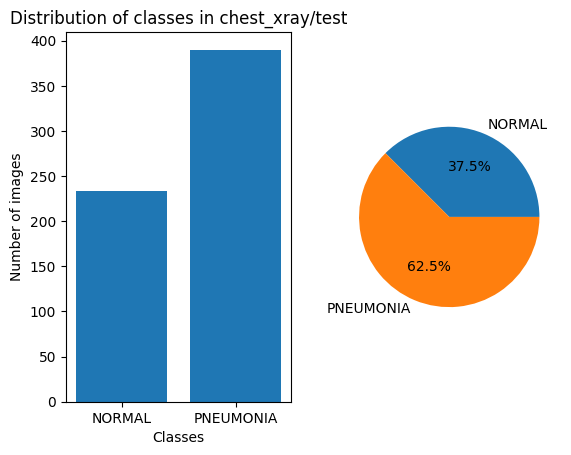

chest_xray/val

Class: NORMAL, Number of images: 8, percentage: 50.00%
Class: PNEUMONIA, Number of images: 8, percentage: 50.00%
Number of images:  16 
Classes:  ['NORMAL', 'PNEUMONIA'] 
Class to index mapping:  {'NORMAL': 0, 'PNEUMONIA': 1} 



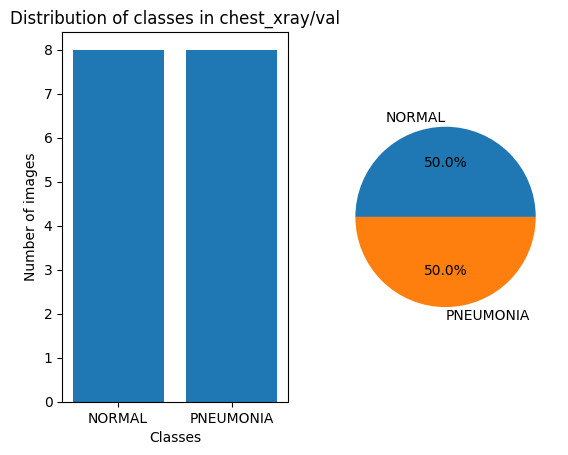

In [7]:
content = ["chest_xray/train", "chest_xray/test", "chest_xray/val"]

for path_ in content:
    dataset = torchvision.datasets.ImageFolder(os.path.join(path, path_))

    classes = dataset.classes
    lenght = len(dataset)
    index = dataset.class_to_idx
    targets = dataset.targets
    stats = Counter(dataset.targets)
    print(f"{path_}\n")

    for i in index.keys():
        for j in stats.keys():
            if index[i] == j:
                print(f"Class: {i}, Number of images: {stats[j]}, percentage: {stats[j]/lenght:.2%}")

    print("Number of images: ", lenght, "\nClasses: ", classes, "\nClass to index mapping: ", index, "\n")

    plt.subplot(1, 2, 1)
    plt.bar(stats.keys(), stats.values())
    plt.xticks(list(index.values()), list(index.keys()))
    plt.xlabel("Classes")
    plt.ylabel("Number of images")
    plt.title(f"Distribution of classes in {path_}")

    plt.subplot(1, 2, 2)
    plt.pie(stats.values(), labels=list(index.keys()), autopct="%1.1f%%")
    plt.show()


Nous observons respectivement 5216, 624 et 16 images dans les dossiers train, test et validation. Dans le dossier train il y a 3875 images de pneumonie et 1341 images normales. Le dossier test contient 390 images de pneumonie contre 234 images normales. Enfin, pour le dossier de validation, celui-ci ne comporte que 16 images, 8 pour chaque classe. Cela signifie que si le modèle se trompe sur 2 images, l'accuracy chute de 12%.

Ces observations montrent que le jeu de données souffre d'un déséquilibre de classes significatif (ratio 3:1). De plus, l'échantillon de validation est statistiquement trop faible pour servir de métrique de pilotage fiable durant l'entraînement. Il sera donc impératif de procéder à un re-splitting des données pour garantir une évaluation robuste.

# Visualisation

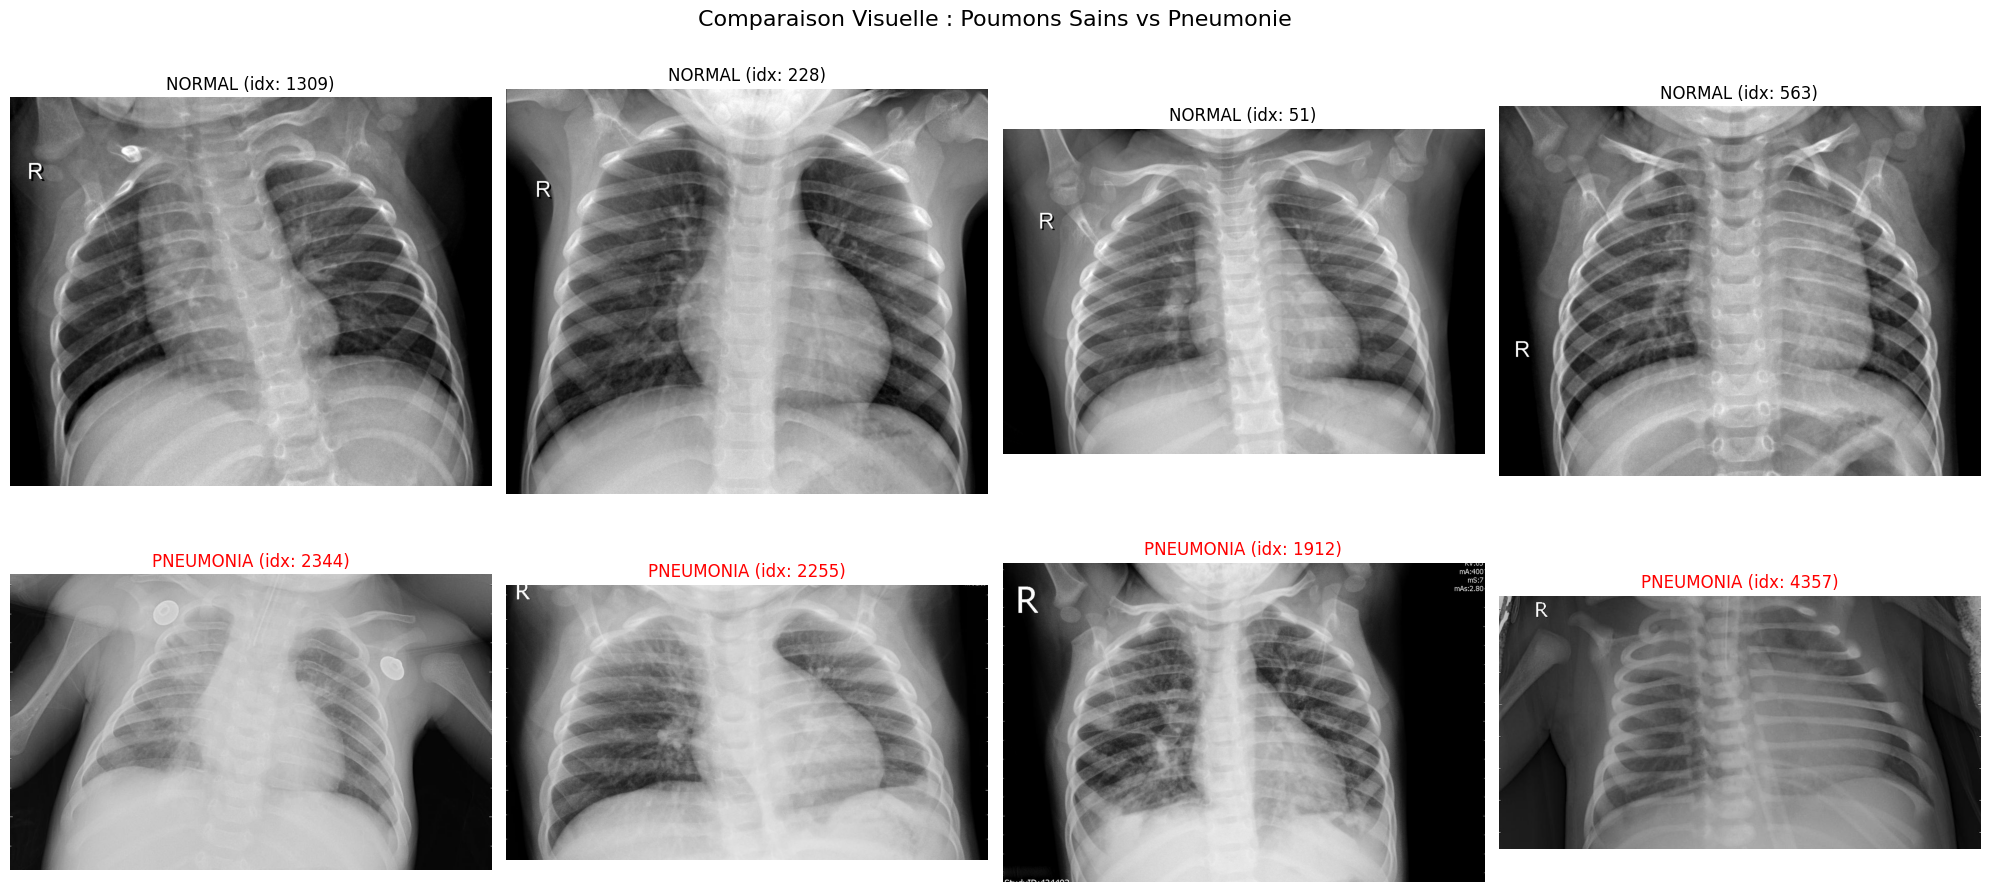

In [8]:
train_dataset = torchvision.datasets.ImageFolder(os.path.join(path, "chest_xray/train"))

normal_indices = [i for i, label in enumerate(train_dataset.targets) if label == 0]
pneumonia_indices = [i for i, label in enumerate(train_dataset.targets) if label == 1]

random.seed(42) # permet d'obtenir les mêmes échantillons à chaque exécution    
sample_normal = random.sample(normal_indices, 4)
sample_pneumonia = random.sample(pneumonia_indices, 4)

fig, axes = plt.subplots(2, 4, figsize=(20, 10))

for i, idx in enumerate(sample_normal):
    img, label = train_dataset[idx]
    axes[0, i].imshow(img, cmap='gray')
    axes[0, i].set_title(f"NORMAL (idx: {idx})")
    axes[0, i].axis('off')

for i, idx in enumerate(sample_pneumonia):
    img, label = train_dataset[idx]
    axes[1, i].imshow(img, cmap='gray')
    axes[1, i].set_title(f"PNEUMONIA (idx: {idx})", color='red')
    axes[1, i].axis('off')

plt.suptitle("Comparaison Visuelle : Poumons Sains vs Pneumonie", fontsize=16)
plt.tight_layout()
plt.show()

La visualisation révèle que les cas de pneumonie présentent des couleurs blanchâtres, les poumons sains sont quant à eux plus sombres. Certaines images contiennent la lettre R. Ces observations justifient l'utilisation d'augmentation de données comme le contraste aléatoire et de légères rotations.

# Moyenne et écart-type

In [10]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_path = os.path.join(path, "chest_xray/train")
train_dataset = datasets.ImageFolder(train_path, transform=transform)
loader = DataLoader(train_dataset, batch_size=64, shuffle=False, num_workers=2)

def get_stats(loader):
    mean = 0.0
    std = 0.0
    total_images = 0
    
    print("Calcul en cours sur le set d'entraînement...")
    for images, _ in tqdm(loader):
        # images shape: [batch_size, channels, height, width]
        batch_samples = images.size(0) 
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images += batch_samples

    mean /= total_images
    std /= total_images
    
    return mean, std

mean, std = get_stats(loader)

print(f"\nMoyenne (Mean) : {mean}")
print(f"Écart-type (Std) : {std}")

Calcul en cours sur le set d'entraînement...


100%|██████████| 82/82 [01:07<00:00,  1.22it/s]


Moyenne (Mean) : tensor([0.4823, 0.4823, 0.4823])
Écart-type (Std) : tensor([0.2216, 0.2216, 0.2216])


In [11]:
MEAN = [0.4823, 0.4823, 0.4823]
STD = [0.2216, 0.2216, 0.2216]
BATCH_SIZE = 64
base_path = os.path.join(path, "chest_xray")

# Data Augmentation

In [12]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
])

On resize tous les échantillons, on les normalise et on les transforme en tenseur PyTorch. La Data Augmentation est réalisée sur les données d'entraînement. L'objectif est d'éviter au modèle d'apprendre les images par coeur, certaines images, aléatoirement choisies, sont donc pivoter, des changements de couleurs sont effectuer pour simuler différentes machines de radiologie etc.

# On augmente le nombre d'échantillons en validation

In [13]:
train_ds_aug = datasets.ImageFolder(os.path.join(base_path, "train"), transform=train_transform)
train_ds_clean = datasets.ImageFolder(os.path.join(base_path, "train"), transform=val_test_transform)

train_size = int(0.9 * len(train_ds_aug))
val_extra_size = len(train_ds_aug) - train_size
indices = torch.randperm(len(train_ds_aug), generator=torch.Generator().manual_seed(42))

train_indices = indices[:train_size]
val_extra_indices = indices[train_size:]

train_subset = Subset(train_ds_aug, train_indices)
val_extra_subset = Subset(train_ds_clean, val_extra_indices)

In [14]:
original_val_ds = datasets.ImageFolder(os.path.join(base_path, "val"), transform=val_test_transform)
final_val_dataset = ConcatDataset([original_val_ds, val_extra_subset])

In [15]:
test_dataset = datasets.ImageFolder(os.path.join(base_path, "test"), transform=val_test_transform)

In [16]:
train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(final_val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print(f"Pipeline MLOps prêt !")
print(f"--- Train : {len(train_subset)} images (Augmentées)")
print(f"--- Val   : {len(final_val_dataset)} images (Propres)")
print(f"--- Test  : {len(test_dataset)} images (Propres)")

Pipeline MLOps prêt !
--- Train : 4694 images (Augmentées)
--- Val   : 538 images (Propres)
--- Test  : 624 images (Propres)


On obtient un découpage 80/10/10

# Baseline

In [17]:
baseline_metrics = {
    'mean': MEAN,
    'std': STD,
    'class_mapping': train_ds_aug.class_to_idx,
    'split_ratios': {'train': 0.8, 'val': 0.1, 'test': 0.1}
}
torch.save(baseline_metrics, "baseline_metrics.pt")